# BALC cleaning 
Elena Cimino
e.cimino@pitt.edu

## Goal
The goal for this notebook is to clean up and process BALC. Some of the tagging is inconsistent, so I would like to normalize it. Then, I'll remove it, since I don't actually need any information about orthographic knowledge. Aditionally, I'll be running some measures that will give me an idea about some descriptive statistics for the corpus texts and a bit more about the lexical diversity of each document. 

To see my exploration of spaCy and why I used its lemmatizer over NLTK's, you can head over here to [exploring_spaCy.ipynb](https://nbviewer.jupyter.org/github/Data-Science-for-Linguists-2019/ESL-Article-Acquisition/blob/master/exploratory-analysis/exploring_spaCy.ipynb).

### Table of Contents:
1. [Setup](#setup): setting up the notebook, reading in files, loading libraries
2. [cepa_df](#cepadf): initializing the main dataframe: `cepa_df`, comprised of the CEPA texts in BALC
3. [Cleaning cepa_df](#clean): cleaning up `cepa_df` and the documents in it, normalizing
4. [Expanding cepa_df](#expand): 'revise' essays, supply basic information about texts
5. [Descriptives](#describe): a little bit about text length, TTR, Guiarud's R, etc.
6. [Visualization](#see): some plotting, graphs
7. [Conclusion](#conclusion): wrapping up what was found out in this notebook

<a id='setup'></a>
## Initial set-up
Reading in libraries, files, etc.

In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk
import glob
import re
import string

import spacy
nlp = spacy.load('en')

import math

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pprint            # to turn off pretty printing

Pretty printing has been turned OFF


In [3]:
cor_dir = "../private/BUiD Arab Learner Corpus v.1/total/"
corpus = glob.glob(cor_dir+'*.txt')
corpus[:5]

['../private/BUiD Arab Learner Corpus v.1/total/CEPA 3 200607296.txt', '../private/BUiD Arab Learner Corpus v.1/total/CEPA 4 200607457.txt', '../private/BUiD Arab Learner Corpus v.1/total/CEPA 5 200600487.txt', '../private/BUiD Arab Learner Corpus v.1/total/CEPA 4 200608016.txt', '../private/BUiD Arab Learner Corpus v.1/total/CEPA 1 200611825.txt']

There are some duplicates in the total folder, which I'm using for the corpus root. The majority of these are cross-listed in two different proficiency levels (a few are in the same folder, but have two different file names with different spacing). 

I was able to locate the correctly labeled files (`clean_files`) in the CEPA Images folder, where all the original handwritten essays are located. Therefore, during my exploration of the corpus, I picked the duplicated (`bad_files`) as well as the clean files. I'll be using these two variables to point my code in the correct direction when it comes to these specific files, so that we don't have essays incorrectly labeled or duplicated files.

In [4]:
# Opening the pickle files that have the problem files... 
f_in = open("duplicated_files.pickle","rb")
bad_files = pickle.load(f_in)
f_in.close()

# ... and the clean files
f_in = open("clean_files.pickle","rb")
clean_files = pickle.load(f_in)
f_in.close()

# checking the variables and making sure this looks right
bad_files
clean_files

['200607856', '200607880', '200607857', '200607777', '200607875', '200607861', '200607902', '200607910', '200612324', '200611115', '200621158', '200619773']

['../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607777.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607856.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607880.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607857.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200612324.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607902.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607861.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607875.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607910.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/3/200611115.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/6/200621158.jpg', '../private/BUiD Arab Learner Corpus v.1/CEPA Images/6/200619773.jpg']

Yes, those are looking good! `bad_files` is a list of the duplicated files, and `clean_files` is the list of the correct location. The `clean_files` gives us which location in total we should head to to get the file (e.g. level 2, if a file is cross-listed in levels 1 and 2).

Let's make sure the code will spit out the correct file.

In [5]:
for item in clean_files:
    if any(search in item for search in bad_files):
        print("use:", item)

use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607777.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607856.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607880.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607857.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200612324.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607902.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607861.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607875.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/2/200607910.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/3/200611115.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/6/200621158.jpg
use: ../private/BUiD Arab Learner Corpus v.1/CEPA Images/6/200619773.jpg


In [6]:
# setting up a cepa dict
corpus = glob.glob(cor_dir+'*.txt')
corpus_dict = {}
for file in corpus:
    start = file.rindex('/')+1
    name = file[start:-4]
    x = re.findall(r'^((C|c).*?\d{3,}( -)?)', name)   
    if len(x) > 0:
            x = x[0][0].split()
            if x[-1] not in bad_files:  # duplicated files - ignoring them for now, will put in a separate dict and concatenate
                f = open(file, encoding='utf-8-sig')   # fixes \ufeff code at beginning of strings
                txt = f.read()
                f.close()
                corpus_dict[x[-1]] = {"Level": x[1], "Text": txt}
len(corpus_dict.keys())

1652

In [7]:
# This is for the bad files. There should be twelve of them!
mini = {}
for item in clean_files:
    if any(search in item for search in bad_files):
        x = re.findall(r'\d/\d+', item)   # gets the level (/\d/) and the file (\d+) information
        x = x[0]
        x = x.split('/')
        fn = cor_dir+"CEPA "+str(x[0])+" "+str(x[1])+".txt"
        print(x, fn)
        f = open(fn, encoding='utf-8-sig')
        txt = f.read()
        f.close()
        mini[x[1]] = {"Level": x[0], "Text": txt}
len(mini.keys())
mini['200607777']["Text"]

['2', '200607777'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607777.txt
['2', '200607856'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607856.txt
['2', '200607880'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607880.txt
['2', '200607857'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607857.txt
['2', '200612324'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200612324.txt
['2', '200607902'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607902.txt
['2', '200607861'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607861.txt
['2', '200607875'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607875.txt
['2', '200607910'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 2 200607910.txt
['3', '200611115'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 3 200611115.txt
['6', '200621158'] ../private/BUiD Arab Learner Corpus v.1/total/CEPA 6 200621158.txt
['6', '200619773'] ../private/BUiD Arab Learner Corpus

12

'\t\t\t\tCEPA 2 200607777\n\n\n\nThe perfet holiday in UAE. You went suren cantres to one holiday. went with you me sister and mather. I’m see in Abu Dhabie “shate alraha” is a very nice sea and I went “Al maryna moll”. alfter is going to AlAin. it very nice, I went “  Mouten of hafied” and “mobazar AlKadra”. In Dubai went to the “meina salam” and “almaha” is a nice hotiel in Dubai. In RAK is go in masafi and see the water of masafi. wheth alfugaira isvery nise cantry because is have more of mouten”\nThe ajnan amalguin is avery smoler than save cantres. it was so wonderful because I’m going xxx with father and sister. went to sven emarit. I’m very happey to see emarat in  one holiday.\n'

In [8]:
# Concatenating corpus_dict and mini, making sure they have the right amount of keys
z = {**corpus_dict, **mini}
len(z.keys())

1664

<a id='cepadf'></a>
## Setting up cepa_df

In [9]:
cepa_df = pd.DataFrame(list(z.keys()), columns={"Filename"})
cepa_df.shape
cepa_df.head()

(1664, 1)

,Filename
0,200607296
1,200607457
2,200600487
3,200608016
4,200611825


In [10]:
# UDFs to get the level and the original text
def get_level(file):
    return z[file]["Level"]

def get_text(file):
    return z[file]["Text"]

In [11]:
cepa_df["Level"] = cepa_df.Filename.apply(get_level)
cepa_df["Original_Text"] = cepa_df.Filename.apply(get_text)
cepa_df.head()

,Filename,Level,Original_Text
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...
4,200611825,1,\t\t\t\tCEPA 1 200611825\n\n\n\nyou go in the ...


<a id='clean'></a>
## Cleaning data
It's time to get clean up these files! We can see from the DataFrame and dict entries above that these files all have a lot of white space, as well as a header with the file name. We don't need that! 

In this section, I:
- Remove excessive whitespace and things like curly quotes (`clean_text`)
- Standardize tagging (`re-tag`)
    - `<o>...</o>` -> `_`
    - `<i>...</i>` -> `^`
    - `<x>...</x>` -> `~~`
- Remove headers (`un_head`)

In [12]:
def clean_text(txt):
    """Removes excessive whitespace, backticks, and curly quotes from a text."""
    txt = re.sub(r'[\n\t ]+', ' ', txt)
    txt = re.sub(r'^`', '', txt)
    txt = txt.replace('“','"').replace('”','"').replace("’", "'")
    txt = txt.strip()
    return txt

def retag(essay):
    """Replaces tags for student emphasis (<o>, </o>)with '_' and removes any unecessary spaces between emphasized 
    letters in words. Replaces tags for student insertions (<i>, </i>) with '^' and removes any unecessary spaces 
    between letters in inserted words. Replaces cross-out tags (<x>, </x>) with '~~' Removes any left over brackets."""
    essay = re.sub(r'\<i +', '<i>', essay)
    essay = re.sub(r'<x +', '<x>', essay)
    essay = re.sub(r'<o +', '<o>', essay)
    essay = re.sub(r'<\/o[^>]', '</o>', essay)
    essay = re.sub(r'<o>(\s)?', '_', essay)
    essay = re.sub(r'(\s)?<\/o>', '_', essay)
    essay = re.sub(r'<i>(\s)?', '^', essay)
    essay = re.sub(r'(\s)?<\/i>', '^', essay)
    essay = re.sub(r'</?x>', '~~', essay)
    essay = re.sub(r'>', ' ', essay)
    essay = re.sub(r'<', ' ', essay)
    return essay

def un_head(txt):
    """Removes headers from text that include the file name, as well as student's names, grades, schools, etc."""
    cepa = re.compile(r'^C(EPA|EPa|epa)')      
    if cepa.search(txt):
        txt = re.sub(r'CEPA.*?\d{2,}( ?-)?', '', txt, flags=re.I) 
    return txt

def normalize_essay(txt):
    txt = clean_text(txt)
    txt = retag(txt)
    txt = un_head(txt)
    txt = txt.strip()
    return txt

Now let's check the UDFs out to make sure they work!

In [13]:
# Original file
cepa_df.Original_Text[1524]

"\t\t\t\tCEPA 2 200606375\n\n\n\nthe most beau<o>u</otiful pla<x>c</x>e you know in <o>A</o>l Hilly . I like go to the allh<x>i</x>lly because I'm play geam and look in the most beautiful . I play foot ball , tens basketball and play geam to t<x>h</x>e car . I'm look to the sea. I'm go to the AllHilly on frend .your go in the play <o>and aet</o>. I should you go in the All Hilly sawfa li<x>k</x>e and love . because in the be<x>a</x>utiful place. why I like it so much ? <x>beaucse</x> beautiful place and I'm go to AllHelly only Time. what you do eat ?? I'm eat to Hamborgar , Frish and Asier .Thnke you.\n"

In [14]:
# Cleaning it
clean_text(cepa_df.Original_Text[1524])

"CEPA 2 200606375 the most beau<o>u</otiful pla<x>c</x>e you know in <o>A</o>l Hilly . I like go to the allh<x>i</x>lly because I'm play geam and look in the most beautiful . I play foot ball , tens basketball and play geam to t<x>h</x>e car . I'm look to the sea. I'm go to the AllHilly on frend .your go in the play <o>and aet</o>. I should you go in the All Hilly sawfa li<x>k</x>e and love . because in the be<x>a</x>utiful place. why I like it so much ? <x>beaucse</x> beautiful place and I'm go to AllHelly only Time. what you do eat ?? I'm eat to Hamborgar , Frish and Asier .Thnke you."

In [15]:
# Un-heading the cleaned file
un_head(clean_text(cepa_df.Original_Text[1524]))

" the most beau<o>u</otiful pla<x>c</x>e you know in <o>A</o>l Hilly . I like go to the allh<x>i</x>lly because I'm play geam and look in the most beautiful . I play foot ball , tens basketball and play geam to t<x>h</x>e car . I'm look to the sea. I'm go to the AllHilly on frend .your go in the play <o>and aet</o>. I should you go in the All Hilly sawfa li<x>k</x>e and love . because in the be<x>a</x>utiful place. why I like it so much ? <x>beaucse</x> beautiful place and I'm go to AllHelly only Time. what you do eat ?? I'm eat to Hamborgar , Frish and Asier .Thnke you."

In [16]:
#re-tag 
retag(un_head(clean_text(cepa_df.Original_Text[1524])))

" the most beau_u_iful pla~~c~~e you know in _A_l Hilly . I like go to the allh~~i~~lly because I'm play geam and look in the most beautiful . I play foot ball , tens basketball and play geam to t~~h~~e car . I'm look to the sea. I'm go to the AllHilly on frend .your go in the play _and aet_. I should you go in the All Hilly sawfa li~~k~~e and love . because in the be~~a~~utiful place. why I like it so much ? ~~beaucse~~ beautiful place and I'm go to AllHelly only Time. what you do eat ?? I'm eat to Hamborgar , Frish and Asier .Thnke you."

In [17]:
# normalize combines all three UDFs
normalize_essay(cepa_df.Original_Text[1524])

"the most beau_u_iful pla~~c~~e you know in _A_l Hilly . I like go to the allh~~i~~lly because I'm play geam and look in the most beautiful . I play foot ball , tens basketball and play geam to t~~h~~e car . I'm look to the sea. I'm go to the AllHilly on frend .your go in the play _and aet_. I should you go in the All Hilly sawfa li~~k~~e and love . because in the be~~a~~utiful place. why I like it so much ? ~~beaucse~~ beautiful place and I'm go to AllHelly only Time. what you do eat ?? I'm eat to Hamborgar , Frish and Asier .Thnke you."

In [18]:
cepa_df['Normalized_Essay'] = cepa_df.Original_Text.apply(normalize_essay)
cepa_df.head()

,Filename,Level,Original_Text,Normalized_Essay
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...,Every body in this life have a favourite posse...
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...,Every body have a lot ofpossessions in this li...
4,200611825,1,\t\t\t\tCEPA 1 200611825\n\n\n\nyou go in the ...,you go in the oman just had the perfect holida...


<a id='expand'></a>
## Expanding on cepa_df

In this section, I will:
- Remove all student correction tags (`remove_tags`, creates `Revised_Essay`)
- Tokenize (based on revised_essay)
- Get token counts (based on revised_essay)
- Get TTR and Guiraud's R (based on revised_essay)
- Lemmatize using spaCy

In [19]:
def remove_tags(text):
    """Removes tags from Normalized_Essay. If there are tags indicating a student crossed something out, whatever is 
    enclosed in those tags is removed."""
    text = re.sub(r'~~.*?~~', '', text)         
    text = text.replace('_', '').replace('^', '')   
    return text

In [20]:
cepa_df['Revised_Essay'] = cepa_df.Normalized_Essay.apply(remove_tags)
cepa_df['tokens'] = cepa_df.Revised_Essay.apply(nltk.word_tokenize)
cepa_df['token_count'] = cepa_df.tokens.map(len)
cepa_df.sample(5)

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count
677,200607951,5,\t\t\t\tCEPA 5 200607951\n\n\n\nI lived the mo...,I lived the most intresting summer last year. ...,I lived the most intresting summer last year. ...,"[I, lived, the, most, intresting, summer, last...",306
771,200619823,6,\t\t\t\tCEPA 6 200619823\n\n\n\t\t\t\t ...,Topic A My trip last summer like every summer ...,Topic A My trip last summer like every summer ...,"[Topic, A, My, trip, last, summer, like, every...",314
183,200612510,3,\t\t\t\tCEPA 3 200612510\n\n\n\nIn my life I s...,In my life I spend bad weekend xxx I went to A...,In my life I spend bad weekend xxx I went to A...,"[In, my, life, I, spend, bad, weekend, xxx, I,...",169
1475,200608349,5,\t\t\t\tCEPA 5 200608349\n\n\n\nLast summer ho...,Last summer holiday I traveled to South of Afr...,Last summer holiday I traveled to South of Afr...,"[Last, summer, holiday, I, traveled, to, South...",274
682,200610633,1,\t\t\t\tCEPA 1 200610633\n\n\n\nI am have just...,I am have just had worst holiday ever I want t...,I am have just had worst holiday ever I want t...,"[I, am, have, just, had, worst, holiday, ever,...",56


Great! Let's keep truckin' along!

In [21]:
# Let's get TTR
def get_TTR(toks):
    """All tokens are lowercased, punctuation is included.
    Get TTR by dividing set of lowercased tokens by length of tokens."""
    all_toks = [x.lower() for x in toks]
    if len(all_toks) == 0:  
        return 0
    else: return len(set(all_toks))/len(all_toks)

In [22]:
cepa_df['TTR'] = cepa_df.tokens.apply(get_TTR)
cepa_df.head(3)

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...,Now I tell you why my worst holiday ever in th...,"[Now, I, tell, you, why, my, worst, holiday, e...",207,0.492754
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...,My worst holiday Last year I have just had the...,"[My, worst, holiday, Last, year, I, have, just...",180,0.572222
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...,Every body in this life have a favourite posse...,Every body in this life have a favourite posse...,"[Every, body, in, this, life, have, a, favouri...",229,0.445415


In [23]:
# adding Guirard's R
def get_GUI(toks):
    """All tokens are lowercased, punctuation is included.
    Get Guiraud's R measure of lexical complexity by dividing set of lowercased tokens by the square root of total number of tokens.
    Guiraud (1954)"""
    all_toks = [x.lower() for x in toks]
    if len(all_toks) == 0:
        return 0
    else: return len(set(all_toks))/math.sqrt(len(all_toks))
    
cepa_df['Guiraud'] = cepa_df.tokens.apply(get_GUI)

cepa_df.head()

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR,Guiraud
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...,Now I tell you why my worst holiday ever in th...,"[Now, I, tell, you, why, my, worst, holiday, e...",207,0.492754,7.089490
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...,My worst holiday Last year I have just had the...,"[My, worst, holiday, Last, year, I, have, just...",180,0.572222,7.677167
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...,Every body in this life have a favourite posse...,Every body in this life have a favourite posse...,"[Every, body, in, this, life, have, a, favouri...",229,0.445415,6.740350
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...,Every body have a lot ofpossessions in this li...,Every body have a lot ofpossessions in this li...,"[Every, body, have, a, lot, ofpossessions, in,...",156,0.608974,7.606087
4,200611825,1,\t\t\t\tCEPA 1 200611825\n\n\n\nyou go in the ...,you go in the oman just had the perfect holida...,you go in the oman just had the perfect holida...,"[you, go, in, the, oman, just, had, the, perfe...",27,0.629630,3.271652


In [24]:
lemmas = []
pos = []

for doc in nlp.pipe(cepa_df.Revised_Essay.astype('unicode').values):
    lemmas.append([n.lemma_ for n in doc])
    pos.append([(n, n.tag_) for n in doc])

In [25]:
cepa_df['pos'] = pos
cepa_df['lemmas'] = lemmas
cepa_df.head()

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR,Guiraud,pos,lemmas
0,200607296,3,\t\t\t\tCEPA 3 200607296\n\n\n\nNow I tell you...,Now I tell you why my worst holiday ever in th...,Now I tell you why my worst holiday ever in th...,"[Now, I, tell, you, why, my, worst, holiday, e...",207,0.492754,7.089490,"[(Now, RB), (I, PRP), (tell, VBP), (you, PRP),...","[now, -PRON-, tell, -PRON-, why, -PRON-, bad, ..."
1,200607457,4,\t\t\t\tCEPA 4 200607457\n\n\n\n ...,My worst holiday Last year I have just had the...,My worst holiday Last year I have just had the...,"[My, worst, holiday, Last, year, I, have, just...",180,0.572222,7.677167,"[(My, PRP$), (worst, JJS), (holiday, NN), (Las...","[-PRON-, bad, holiday, last, year, -PRON-, hav..."
2,200600487,5,\t\t\t\tCEPA 5 200600487\n\n\n\n\nEvery body i...,Every body in this life have a favourite posse...,Every body in this life have a favourite posse...,"[Every, body, in, this, life, have, a, favouri...",229,0.445415,6.740350,"[(Every, DT), (body, NN), (in, IN), (this, DT)...","[every, body, in, this, life, have, a, favouri..."
3,200608016,4,\t\t\t\tCEPA 4 200608016\n\n\n\nEvery body hav...,Every body have a lot ofpossessions in this li...,Every body have a lot ofpossessions in this li...,"[Every, body, have, a, lot, ofpossessions, in,...",156,0.608974,7.606087,"[(Every, DT), (body, NN), (have, VBP), (a, DT)...","[every, body, have, a, lot, ofpossession, in, ..."
4,200611825,1,\t\t\t\tCEPA 1 200611825\n\n\n\nyou go in the ...,you go in the oman just had the perfect holida...,you go in the oman just had the perfect holida...,"[you, go, in, the, oman, just, had, the, perfe...",27,0.629630,3.271652,"[(you, PRP), (go, VBP), (in, IN), (the, DT), (...","[-PRON-, go, in, the, oman, just, have, the, p..."


Now we need to take a closer look at the lemmas... Our lemma list is nested, so we'll need to flatten it first. We'll ignore essays less than 6 tokens long for the time being.

In [26]:
filtered = (cepa_df.token_count >= 6)
all_lemmas_flat = [x for y in cepa_df[filtered].lemmas for x in y]
all_lemmas_flat[:100]
len(all_lemmas_flat)

['now', '-PRON-', 'tell', '-PRON-', 'why', '-PRON-', 'bad', 'holiday', 'ever', 'in', 'the', 'last', 'summer', '-PRON-', 'went', 'withe', '-PRON-', 'family', 'in', 'the', 'india', 'and', 'this', 'story', '-PRON-', 'will', 'tell', '-PRON-', 'what', 'happen', 'for', 'the', 'short', 'story', 'when', '-PRON-', 'go', 'the', 'first', 'the', 'weathe', 'be', 'very', 'very', 'rain', 'now', 'bady', 'for', 'the', 'child', 'play', 'out', 'when', '-PRON-', 'go', 'in', 'the', 'hotel', 'all', 'may', 'family', 'be', 'have', 'the', 'headk', 'in', 'there', 'and', 'all', 'be', 'sleep', 'put', 'for', '-PRON-', '-PRON-', 'can;t', 'sleep', 'because', '-PRON-', 'not', 'love', 'the', 'area', 'in', 'the', 'morning', 'all', 'the', '-PRON-', 'family', 'weak', 'up', 'and', 'go', 'irant', 'but', 'be', 'the', 'stree', ',']

267270

Now, let's throw ignore punctuation and the -PRON- tag.

In [27]:
filtered_lemmas_flat = []

for lem in all_lemmas_flat:
    if lem not in string.punctuation:  
        if lem != '-PRON-':            
            filtered_lemmas_flat.append(lem)

all_lemmas_flat[:100]
filtered_lemmas_flat[:100]

['now', '-PRON-', 'tell', '-PRON-', 'why', '-PRON-', 'bad', 'holiday', 'ever', 'in', 'the', 'last', 'summer', '-PRON-', 'went', 'withe', '-PRON-', 'family', 'in', 'the', 'india', 'and', 'this', 'story', '-PRON-', 'will', 'tell', '-PRON-', 'what', 'happen', 'for', 'the', 'short', 'story', 'when', '-PRON-', 'go', 'the', 'first', 'the', 'weathe', 'be', 'very', 'very', 'rain', 'now', 'bady', 'for', 'the', 'child', 'play', 'out', 'when', '-PRON-', 'go', 'in', 'the', 'hotel', 'all', 'may', 'family', 'be', 'have', 'the', 'headk', 'in', 'there', 'and', 'all', 'be', 'sleep', 'put', 'for', '-PRON-', '-PRON-', 'can;t', 'sleep', 'because', '-PRON-', 'not', 'love', 'the', 'area', 'in', 'the', 'morning', 'all', 'the', '-PRON-', 'family', 'weak', 'up', 'and', 'go', 'irant', 'but', 'be', 'the', 'stree', ',']

['now', 'tell', 'why', 'bad', 'holiday', 'ever', 'in', 'the', 'last', 'summer', 'went', 'withe', 'family', 'in', 'the', 'india', 'and', 'this', 'story', 'will', 'tell', 'what', 'happen', 'for', 'the', 'short', 'story', 'when', 'go', 'the', 'first', 'the', 'weathe', 'be', 'very', 'very', 'rain', 'now', 'bady', 'for', 'the', 'child', 'play', 'out', 'when', 'go', 'in', 'the', 'hotel', 'all', 'may', 'family', 'be', 'have', 'the', 'headk', 'in', 'there', 'and', 'all', 'be', 'sleep', 'put', 'for', 'can;t', 'sleep', 'because', 'not', 'love', 'the', 'area', 'in', 'the', 'morning', 'all', 'the', 'family', 'weak', 'up', 'and', 'go', 'irant', 'but', 'be', 'the', 'stree', 'child', 'and', 'the', 'food', 'be', 'very', 'dearty', 'earia', 'not', 'like', 'becuse', 'be', 'not', 'nice']

In [28]:
len(all_lemmas_flat)
len(filtered_lemmas_flat)

267270

208645

So in doing that, we lost about 60,000 lemmas.

In [29]:
filtered_lemma_fd = nltk.FreqDist(filtered_lemmas_flat)
filtered_lemma_fd.most_common(10)

[('the', 13677), ('and', 10492), ('be', 10213), ('to', 8692), ('in', 6122), ('go', 4995), ('a', 3913), ('have', 2823), ('that', 2504), ('of', 2411)]

In [30]:
small_lemmas = filtered_lemma_fd.most_common(3000)
balc_lemmas = [[(lem, count) for (lem, count) in small_lemmas]]

lemma_counts = pd.DataFrame(balc_lemmas, index=[0]).T
lemma_counts.columns = ['pair']
lemma_counts.head()

,pair
0,"(the, 13677)"
1,"(and, 10492)"
2,"(be, 10213)"
3,"(to, 8692)"
4,"(in, 6122)"


In [31]:
# get the lemma 
def get_lem(x):
    return x[0]

# get the count
def get_ct(x):
    return x[1]

lemma_counts['lemma'] = lemma_counts.pair.map(get_lem)
lemma_counts['counts'] = lemma_counts.pair.map(get_ct)
lemma_counts.head()

,pair,lemma,counts
0,"(the, 13677)",the,13677
1,"(and, 10492)",and,10492
2,"(be, 10213)",be,10213
3,"(to, 8692)",to,8692
4,"(in, 6122)",in,6122


In [32]:
# drop 'pair' column
lemma_counts = lemma_counts.drop(columns=['pair'])
lemma_counts.head()

,lemma,counts
0,the,13677
1,and,10492
2,be,10213
3,to,8692
4,in,6122


In [33]:
# saving lemma counts out to a csv file for later use
lemma_counts.to_csv("../private/filtered_balc_lemmas.csv")

# saving cepa files out to csv file in the private folder
cepa_df.to_csv("../private/cepa.csv")

<a id='describe'></a>
## Descriptives
Here, I do two things: I make sure everything is read in correctly, and I look at some basic descriptive stats for the DataFrame, such as the descriptions of token count, TTR, and value counts for the different levels.

In [34]:
# all filenames should have only 1 value
all(cepa_df.Filename.value_counts() == 1)

True

In [35]:
# Size of the DataFrame as is
cepa_df.shape

(1664, 11)

In [36]:
cepa_df.groupby('Level').describe()

Guiraud                                                              \
        count      mean       std       min       25%       50%       75%   
Level                                                                       
1       276.0  4.453267  1.134710  0.000000  3.674235  4.431016  5.144595   
2       292.0  5.125821  0.868385  2.549510  4.587562  5.098895  5.644995   
3       250.0  5.765952  0.861545  3.487429  5.100637  5.759068  6.425288   
4       297.0  6.905933  0.823044  2.236068  6.392330  6.928203  7.483554   
5       299.0  7.412893  0.706253  5.637345  6.928925  7.341303  7.832240   
6       250.0  8.076132  0.734736  6.288943  7.543654  8.000616  8.554658   

                    TTR            ...                       token_count  \
             max  count      mean  ...         75%       max       count   
Level                              ...                                     
1       8.148217  276.0  0.699472  ...    0.792279  1.000000       276.0   
2       8.357143  292.0  0.560516  ...    0.628687  1.000000       292.0   
3       8.606922  250.0  0.506205  ...    0.552984  0.800000       250.0   
4       9.442491  297.0  0.498291  ...    0.537688  1.000000       297.0   
5       9.879188  299.0  0.493398  ...    0.522304  0.643836       299.0   
6      10.266019  250.0  0.521077  ...    0.553594  0.717742       250.0   

                                                                   
             mean        std    min     25%    50%     75%    max  
Level                                                              
1       50.409420  35.132618    0.0   24.75   43.0   65.00  199.0  
2       94.287671  44.056346   10.0   59.75   86.5  123.00  310.0  
3      138.056000  47.681305   38.0  105.25  134.0  164.50  316.0  
4      200.373737  50.291163    5.0  167.00  200.0  232.00  343.0  
5      231.862876  51.702926   97.0  193.50  227.0  272.00  397.0  
6      246.748000  53.685426  116.0  210.00  243.0  281.75  392.0  

[6 rows x 24 columns]

In [37]:
# How many TTRs of 1.0 there are 
cepa_df[cepa_df.TTR == 1]

,Filename,Level,Original_Text,Normalized_Essay,Revised_Essay,tokens,token_count,TTR,Guiraud,pos,lemmas
227,200608341,1,\t\t\t\tCEPA 1 200608341\n\n\n\nI don’t now\n,I don't now,I don't now,"[I, do, n't, now]",4,1.0,2.000000,"[(I, PRP), (do, VBP), (n't, RB), (now, RB)]","[-PRON-, do, not, now]"
538,200606487,1,\t\t\t\tCEPA 1 200606487\n\n\n\nThe mask\nThes...,The mask These film is Dangrs,The mask These film is Dangrs,"[The, mask, These, film, is, Dangrs]",6,1.0,2.449490,"[(The, DT), (mask, NN), (These, DT), (film, NN...","[the, mask, these, film, be, dangrs]"
620,200611449,1,\t\t\t\tCEPA 1 200611449\n\n\n\nOman it agood ...,Oman it agood cantry.,Oman it agood cantry.,"[Oman, it, agood, cantry, .]",5,1.0,2.236068,"[(Oman, VB), (it, PRP), (agood, VBD), (cantry,...","[oman, -PRON-, agood, cantry, .]"
684,200611925,2,\t\t\t\tCEPA 2 200611925\n\n\n\nIm KHALED ABDU...,Im KHALED ABDULLA AL SHAMISI from the UAE. ALAin,Im KHALED ABDULLA AL SHAMISI from the UAE. ALAin,"[Im, KHALED, ABDULLA, AL, SHAMISI, from, the, ...",10,1.0,3.162278,"[(I, PRP), (m, VBP), (KHALED, NNP), (ABDULLA, ...","[-PRON-, be, khaled, abdulla, al, shamisi, fro..."
736,200611666,1,\t\t\t\tCEPA 1 200611666\n\n\n\nSo good weathe...,So good weather in the summer,So good weather in the summer,"[So, good, weather, in, the, summer]",6,1.0,2.449490,"[(So, RB), (good, JJ), (weather, NN), (in, IN)...","[so, good, weather, in, the, summer]"
794,200604490,1,\t\t\t\tCEPA 1 200604490\n\n\n\nyo to <o>AL</o...,yo to _AL_Ain an sammr not Haeep,yo to ALAin an sammr not Haeep,"[yo, to, ALAin, an, sammr, not, Haeep]",7,1.0,2.645751,"[(yo, NNP), (to, IN), (ALAin, NNP), (an, DT), ...","[yo, to, alain, an, sammr, not, haeep]"
922,200606507,1,\t\t\t\tCEPA 1 200606507\n\n\n\nThe Al Ain in ...,The Al Ain in no To fot xxx EYecPh,The Al Ain in no To fot xxx EYecPh,"[The, Al, Ain, in, no, To, fot, xxx, EYecPh]",9,1.0,3.000000,"[(The, DT), (Al, NNP), (Ain, NNP), (in, IN), (...","[the, al, ain, in, no, to, fot, xxx, eyecph]"
1115,200608510,1,\t\t\t\tCEPA 1 200608510\n\n\n\nI you a Oman ....,I you a Oman .I are went there faiml,I you a Oman .I are went there faiml,"[I, you, a, Oman, .I, are, went, there, faiml]",9,1.0,3.000000,"[(I, PRP), (you, PRP), (a, DT), (Oman, NNP), (...","[-PRON-, -PRON-, a, oman, .i, be, go, there, f..."
1187,200612172,1,\t\t\t\tCEPA 1 200612172\n\n\n\nOne fire day w...,One fire day waent to the _cea_nima with ferin...,One fire day waent to the ceanima with ferinds...,"[One, fire, day, waent, to, the, ceanima, with...",13,1.0,3.605551,"[(One, CD), (fire, NN), (day, NN), (waent, NN)...","[one, fire, day, waent, to, the, ceanima, with..."
1337,200603781,1,\t\t\t\tCEPA 1 200603781\n\n\n\nI go to the Du...,I go to the Dubai,I go to the Dubai,"[I, go, to, the, Dubai]",5,1.0,2.236068,"[(I, PRP), (go, VBP), (to, IN), (the, DT), (Du...","[-PRON-, go, to, the, dubai]"


I won't throw these out, but there will need to be a minimum token limit for when I do analysis, so we don't get things like "I don't know" and "Handwriting not legibile".

<a id='see'></a>
## Visualization
Now I want to look at some graphs quickly before wrapping up.

Text(0.5, 1.0, 'Number of Texts per Level (BALC)')

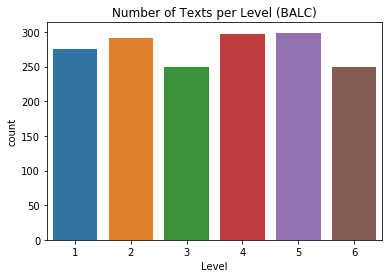

In [38]:
# Let's visualize the amount of files in each level
sns.countplot(x="Level", data=cepa_df)
plt.title('Number of Texts per Level (BALC)')
plt.savefig('../images/balc_texts_per_level.png', bbox_inches = "tight")

We already know the value counts of the levels, but it doesn't hurt to visualize it! Levels 2, 4, and 5 have the most files, getting near to 300. It looks like 3 and 6 have the least amount of files.

Normally, we would expect the least amount of files in higher proficiencies. We would expect to see more files around a medium proficiency, and more low-level files than high-level files. We did see that for the most part in our original .jpg data: Levels 1, 2, 3, and 5 had 300 files each, Level 4 had 298, and Level 6 had 252 files.

Therefore, it looks like we "lost" the most data in Levels 1 and 3. Only a handful of files were dropped from the other levels.

Text(0.5, 1.0, 'Token Count by Level (BALC)')

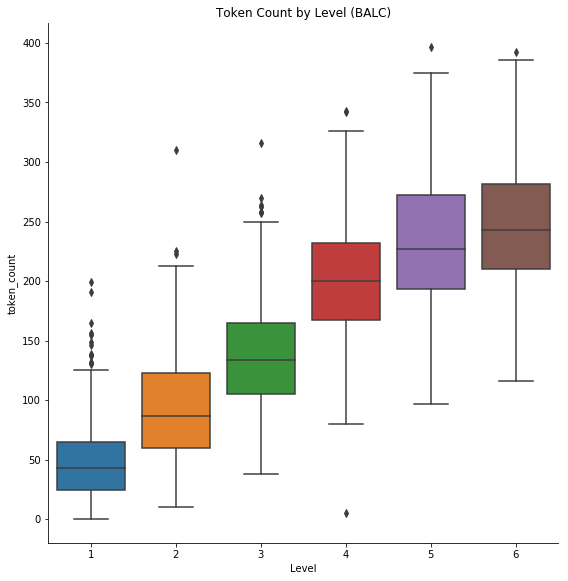

In [39]:
# Let's look at general length by level
sns.catplot(x='Level', y='token_count', kind='box', data=cepa_df, height=8)
plt.title('Token Count by Level (BALC)')
plt.savefig('../images/balc_tokcount.png', bbox_inches = "tight")

In [40]:
lv1_tokct = cepa_df[cepa_df.Level == '1'].token_count # token count for level 1
lv2_tokct = cepa_df[cepa_df.Level == '2'].token_count # token count for level 2
lv3_tokct = cepa_df[cepa_df.Level == '3'].token_count # token count for level 3
lv4_tokct = cepa_df[cepa_df.Level == '4'].token_count # token count for level 4
lv5_tokct = cepa_df[cepa_df.Level == '5'].token_count # token count for level 5
lv6_tokct = cepa_df[cepa_df.Level == '6'].token_count # token count for level 6

stats.f_oneway(lv1_tokct, lv2_tokct, lv3_tokct, lv4_tokct, lv5_tokct, lv6_tokct)

F_onewayResult(statistic=764.373757392868, pvalue=0.0)

Here, we see something that's pretty expected! The higher level students typically write more than the lower level students. There's a handful of outliers, mostly in Level 1. The one-way ANOVA suggests that there is a significant difference between groups here, but we will have to investigate a little bit more to pinpoint exactly where/what it is.

Text(0.5, 1.0, 'TTR By Level (BALC)')

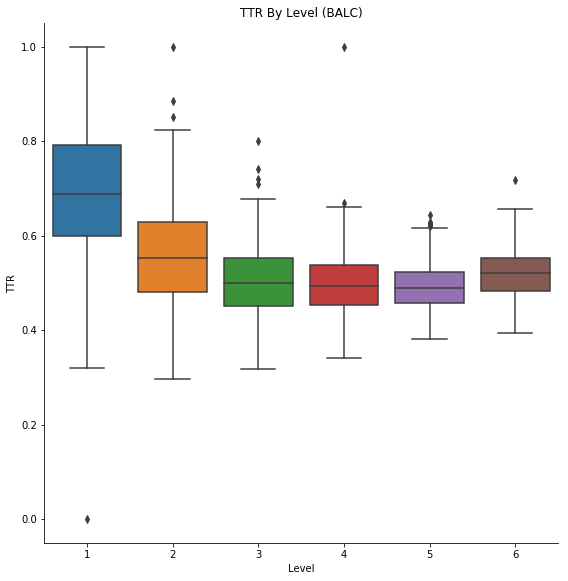

In [41]:
sns.catplot(x='Level', y='TTR', kind='box', data=cepa_df, height=8)
plt.title('TTR By Level (BALC)')
plt.savefig('../images/balc_ttr.png', bbox_inches = "tight")

In [42]:
lv1_ttr = cepa_df[cepa_df.Level == '1'].TTR # ttr for level 1
lv2_ttr = cepa_df[cepa_df.Level == '2'].TTR # ttr for level 2
lv3_ttr = cepa_df[cepa_df.Level == '3'].TTR # ttr for level 3
lv4_ttr = cepa_df[cepa_df.Level == '4'].TTR # ttr for level 4
lv5_ttr = cepa_df[cepa_df.Level == '5'].TTR # ttr for level 5
lv6_ttr = cepa_df[cepa_df.Level == '6'].TTR # ttr for level 6

stats.f_oneway(lv1_ttr, lv2_ttr, lv3_ttr, lv4_ttr, lv5_ttr, lv6_ttr)

F_onewayResult(statistic=208.1989467995349, pvalue=1.6028012530002684e-172)

This really isn't too surprising! The higher the (perceived) level is, the more students seem to write. Conversely, becuase they're writing more, there's more of a likelihood that they'll repeat their words, especially when compared to much lower levels (1, 2). Of course, TTR tells us more when it's normalized/controlled for length, so maybe we can return to this later.

There's a few TTRs of or near 1.0, which means students didn't repeat _any_ words in their essays. Again, that's not too hard to do when you're writing very short essays! However, there's another thing to take into account here: we have seen from our work above that students make a _lot_ of spelling errors, and sometimes the same student will spell the same word several different ways in the same essay! So this measure of TTR still may not have the highest accuracy because students _may actually be repeating words_, but it isn't caught by the TTR function because they're misspelling the word, so they may appear to be different words. Just something to think about!

As with the token count, the one-way ANOVA suggests that there is a significant difference between groups here, though we'll still need to do some digging!

Text(0.5, 1.0, "Guiraud's R by Level (BALC)")

F_onewayResult(statistic=716.2910170871269, pvalue=0.0)

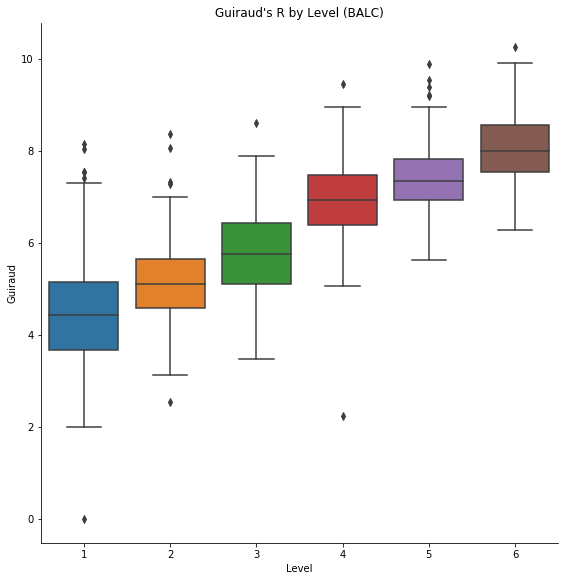

In [43]:
# looking at Guiraud's r
sns.catplot(x='Level', y='Guiraud', kind='box', data=cepa_df, height=8)
plt.title('Guiraud\'s R by Level (BALC)')
plt.savefig('../images/balc_guiraudr.png', bbox_inches = "tight")

lv1_gui = cepa_df[cepa_df.Level == '1'].Guiraud
lv2_gui = cepa_df[cepa_df.Level == '2'].Guiraud 
lv3_gui = cepa_df[cepa_df.Level == '3'].Guiraud 
lv4_gui = cepa_df[cepa_df.Level == '4'].Guiraud 
lv5_gui = cepa_df[cepa_df.Level == '5'].Guiraud 
lv6_gui = cepa_df[cepa_df.Level == '6'].Guiraud 

stats.f_oneway(lv1_gui, lv2_gui, lv3_gui, lv4_gui, lv5_gui, lv6_gui)

Finally, let's save out cepa_df so we can use it later when we need to!

<a id='conclusion'></a>
## Conclusion

So, I've done quite a bit here, I think! I read in all the CEPA files, accounting for duplicates; standardized the tagging in essays, and then removed it; and now I have some specific linguistic data to look at! The essays, tokens, token counts, and TTR so far. I would like to POS tag and possibly lemmatize still, but I think this is a good start.

From my brief (and admittedly pretty shallow) descriptive and quantitative analysis, I found that we still have a pretty good distribution of texts across the different levels. We found that get higher in (perceived) quality/proficiency, they tend to get longer, and their TTR tends to get lower. Again, this is expected, so that's not bad! Both of these differences appear to be signficant.